# EDA — House Prices (Kaggle)

## 0. Setup & Convenciones
Rutas relativas: todo dentro del repo (data/raw/, data/processed/, reports/figs/). Si guardamos archivos, crear carpetas antes para evitar OSError: non-existent directory.

Anti-fugas: toda decisión que use información de SalePrice solo en train. test nunca tiene target (evita KeyError).

Bitácora: cualquier hallazgo/decisión va en reports/bitacora.md (por qué se imputó, por qué se removió un outlier, etc.).

Figuras: guardar gráficos importantes en reports/figs/ (heatmap, outliers, hist de SalePrice).

## 1. Carga de datos

In [55]:
from pathlib import Path
import pandas as pd

# Detectar raíz del proyecto (si estamos dentro de notebooks/, subir un nivel)
CWD = Path.cwd().resolve()
PROJECT_ROOT = CWD.parent if CWD.name == "notebooks" else CWD

DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
FIGS_DIR = PROJECT_ROOT / "reports" / "figs"

# Crear carpetas necesarias (no falla si ya existen)
for p in (DATA_PROCESSED, FIGS_DIR):
    p.mkdir(parents=True, exist_ok=True)

train_path = DATA_RAW / "train.csv"
test_path  = DATA_RAW / "test.csv"

print(f"[cfg] DATA_RAW      : {DATA_RAW}")
print(f"[cfg] DATA_PROCESSED: {DATA_PROCESSED}")
print(f"[cfg] FIGS_DIR      : {FIGS_DIR}")
print(f"[data] train.csv existe: {train_path.exists()} ({train_path})")
print(f"[data] test.csv  existe: {test_path.exists()} ({test_path})")

assert train_path.exists() and test_path.exists(), "Faltan CSV en data/raw/"


[cfg] DATA_RAW      : /mnt/d/Data/0_Ordenado/LM/IA/fast-ia/proyectos/house-prices/data/raw
[cfg] DATA_PROCESSED: /mnt/d/Data/0_Ordenado/LM/IA/fast-ia/proyectos/house-prices/data/processed
[cfg] FIGS_DIR      : /mnt/d/Data/0_Ordenado/LM/IA/fast-ia/proyectos/house-prices/reports/figs
[data] train.csv existe: True (/mnt/d/Data/0_Ordenado/LM/IA/fast-ia/proyectos/house-prices/data/raw/train.csv)
[data] test.csv  existe: True (/mnt/d/Data/0_Ordenado/LM/IA/fast-ia/proyectos/house-prices/data/raw/test.csv)


In [56]:
train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

print("[ok] CSV cargados")
print("train shape:", train.shape)   # esperado: (1460, 81)
print("test  shape:", test.shape)    # esperado: (1459, 80)

# Chequeos clave
assert "SalePrice" in train.columns, "SalePrice no está en train.csv"
assert "SalePrice" not in test.columns, "SalePrice no debería estar en test.csv"

display(train.head(3))


[ok] CSV cargados
train shape: (1460, 81)
test  shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


## 2. Inspección inicial (info/describe)

In [57]:
# --- Resumen de tipos y chequeos clave ---
print("train shape:", train.shape, "| test shape:", test.shape)

# 1) Columnas clave
assert "Id" in train.columns, "Falta columna Id en train"
assert train["Id"].is_unique, "Id no es único en train"
assert "SalePrice" in train.columns, "Falta SalePrice en train"

# 2) Conteo por tipo
dtypes_count = train.dtypes.value_counts()
print("\n[dtypes] Conteo por tipo en train:")
print(dtypes_count)

# 3) Listas de columnas por tipo (para referencia)
num_cols = train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = train.select_dtypes(include=["object"]).columns.tolist()
print(f"\n# num_cols: {len(num_cols)} | # cat_cols: {len(cat_cols)}")
print("Ejemplo num_cols:", num_cols[:10])
print("Ejemplo cat_cols:", cat_cols[:10])

# 4) Columnas constantes (cero varianza)
const_cols = [c for c in train.columns if train[c].nunique(dropna=False) == 1]
print("\n[const] Columnas constantes:", const_cols if const_cols else "Ninguna")

# 5) Duplicados de filas (muy raro, pero chequeamos)
dup_rows = train.duplicated().sum()
print(f"[dups] Filas duplicadas en train: {dup_rows}")


train shape: (1460, 81) | test shape: (1459, 80)

[dtypes] Conteo por tipo en train:
object     43
int64      35
float64     3
Name: count, dtype: int64

# num_cols: 38 | # cat_cols: 43
Ejemplo num_cols: ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1']
Ejemplo cat_cols: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1']

[const] Columnas constantes: Ninguna
[dups] Filas duplicadas en train: 0


In [58]:
# --- Estadísticos de numéricas ---
num_stats = train[num_cols].describe().T[["count", "mean", "std", "min", "max"]]
display(num_stats.head(10))  # muestra las primeras 10 por tamaño


,count,mean,std,min,max
Id,1460.0,730.500000,421.610009,1.0,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,5644.0


In [59]:
# --- Cardinalidad de categóricas ---
import numpy as np

card_cat = train[cat_cols].nunique().sort_values(ascending=False)
print("[card] Top 10 categóricas por cardinalidad:")
display(card_cat.head(10))

# --- Heurística: numéricas con pocos valores únicos (candidatas a 'categorical') ---
num_card = train[num_cols].nunique().sort_values()
candidatas_num_cat = [c for c in num_card.index
                      if num_card[c] <= 15 and c not in ["SalePrice","Id","OverallQual","OverallCond"]]
print("\n[heurística] Numéricas con <=15 valores únicos (candidatas a tratar como categóricas):")
print(candidatas_num_cat)

# Nota didáctica: en House Prices, 'MSSubClass' es un clásico caso numérico->categórico.
if "MSSubClass" in train.columns:
    print("\nSugerencia: 'MSSubClass' suele tratarse como categórica (codifica clase de vivienda).")


[card] Top 10 categóricas por cardinalidad:


Neighborhood    25
Exterior2nd     16
Exterior1st     15
Condition1       9
SaleType         9
HouseStyle       8
RoofMatl         8
Condition2       8
Functional       7
BsmtFinType2     6
dtype: int64


[heurística] Numéricas con <=15 valores únicos (candidatas a tratar como categóricas):
['HalfBath', 'BsmtHalfBath', 'BsmtFullBath', 'FullBath', 'Fireplaces', 'KitchenAbvGr', 'GarageCars', 'YrSold', 'PoolArea', 'BedroomAbvGr', 'TotRmsAbvGrd', 'MoSold', 'MSSubClass']

Sugerencia: 'MSSubClass' suele tratarse como categórica (codifica clase de vivienda).


## 3. Valores faltantes (nulos)

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

def missing_report(df: pd.DataFrame) -> pd.DataFrame:
    miss_pct = df.isna().mean().sort_values(ascending=False)
    miss_cnt = df.isna().sum().loc[miss_pct.index]
    out = pd.DataFrame({"n_missing": miss_cnt, "pct_missing": (miss_pct * 100).round(2)})
    return out[out["n_missing"] > 0]

miss_train = missing_report(train)
miss_test  = missing_report(test)

print("[nulos] columnas con faltantes en train:", miss_train.shape[0])
display(miss_train.head(20))

print("\n[nulos] columnas con faltantes en test:", miss_test.shape[0])
display(miss_test.head(20))


[nulos] columnas con faltantes en train: 19


,n_missing,pct_missing
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
MasVnrType,872,59.73
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageQual,81,5.55
GarageFinish,81,5.55
GarageType,81,5.55



[nulos] columnas con faltantes en test: 33


,n_missing,pct_missing
PoolQC,1456,99.79
MiscFeature,1408,96.50
Alley,1352,92.67
Fence,1169,80.12
MasVnrType,894,61.27
FireplaceQu,730,50.03
LotFrontage,227,15.56
GarageYrBlt,78,5.35
GarageCond,78,5.35
GarageFinish,78,5.35


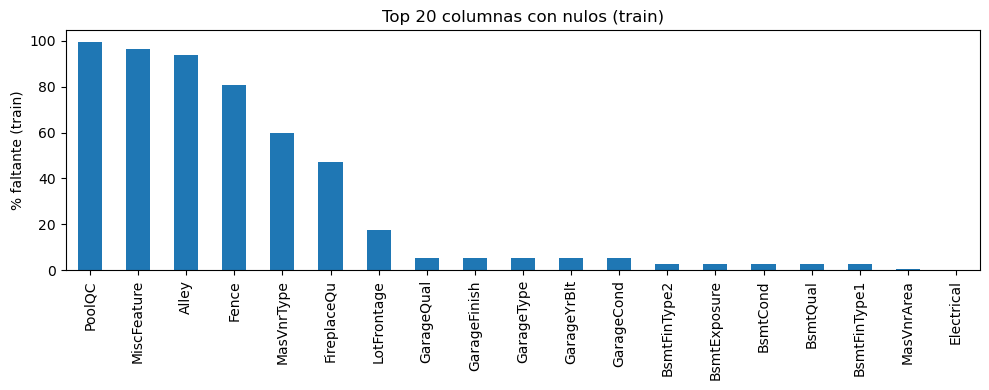

In [61]:
topn = 20
ax = miss_train["pct_missing"].head(topn).plot(kind="bar", figsize=(10,4))
ax.set_ylabel("% faltante (train)")
ax.set_title(f"Top {topn} columnas con nulos (train)")
plt.tight_layout(); plt.show()


In [62]:
def group_missing_fraction(df: pd.DataFrame, groups: dict) -> pd.DataFrame:
    rows = []
    for gname, cols in groups.items():
        cols = [c for c in cols if c in df.columns]
        if not cols:
            continue
        mask_all_na = df[cols].isna().all(axis=1)
        rows.append({
            "group": gname,
            "n_all_na": int(mask_all_na.sum()),
            "pct_all_na": round(mask_all_na.mean()*100, 2),
            "cols": ", ".join(cols[:6]) + ("..." if len(cols) > 6 else "")
        })
    return pd.DataFrame(rows).sort_values("pct_all_na", ascending=False)

groups = {
    "Garage":     [c for c in train.columns if c.startswith("Garage")],
    "Basement":   [c for c in train.columns if c.startswith("Bsmt")],
    "Fireplace":  [c for c in train.columns if c.startswith("Fireplace")],
    "Pool":       [c for c in train.columns if c.startswith("Pool")],
    "Fence":      ["Fence"] if "Fence" in train.columns else [],
    "Alley":      ["Alley"] if "Alley" in train.columns else [],
    "Masonry":    [c for c in train.columns if c.startswith("MasVnr")],
}

group_miss = group_missing_fraction(train, groups)
print("[grupos] filas sin esa característica (todo NA por grupo):")
display(group_miss)


[grupos] filas sin esa característica (todo NA por grupo):


,group,n_all_na,pct_all_na,cols
5,Alley,1369,93.77,Alley
4,Fence,1179,80.75,Fence
6,Masonry,8,0.55,"MasVnrType, MasVnrArea"
2,Fireplace,0,0.00,"Fireplaces, FireplaceQu"
1,Basement,0,0.00,"BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1..."
0,Garage,0,0.00,"GarageType, GarageYrBlt, GarageFinish, GarageC..."
3,Pool,0,0.00,"PoolArea, PoolQC"


## 4. Variable objetivo (SalePrice)

SalePrice — stats básicas
n = 1460
mean = 180921.20 | median = 163000.00
skew = 1.883 | kurtosis = 6.536


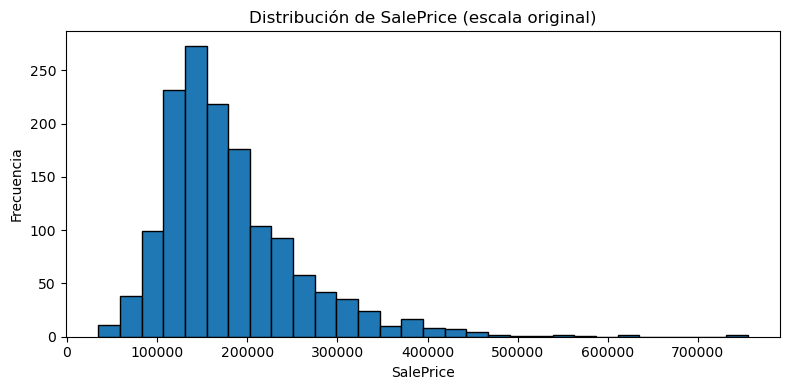

[fig] guardado: /mnt/d/Data/0_Ordenado/LM/IA/fast-ia/proyectos/house-prices/reports/figs/hist_saleprice.png


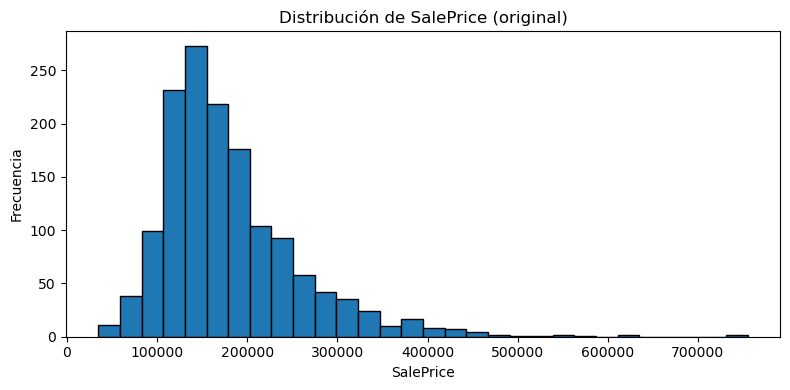

In [63]:
import numpy as np
import matplotlib.pyplot as plt

y = train["SalePrice"].astype(float)

print("SalePrice — stats básicas")
print(f"n = {y.shape[0]}")
print(f"mean = {y.mean():.2f} | median = {y.median():.2f}")
print(f"skew = {y.skew():.3f} | kurtosis = {y.kurt():.3f}")  # kurtosis de Fisher (exceso)

# Histograma (lineal)
plt.figure(figsize=(8,4))
plt.hist(y, bins=30, edgecolor="black")
plt.xlabel("SalePrice"); plt.ylabel("Frecuencia")
plt.title("Distribución de SalePrice (escala original)")
plt.tight_layout()
plt.show()

# Guardar figura
fig_path = FIGS_DIR / "hist_saleprice.png"
plt.figure(figsize=(8,4))
plt.hist(y, bins=30, edgecolor="black")
plt.xlabel("SalePrice"); plt.ylabel("Frecuencia")
plt.title("Distribución de SalePrice (original)")
plt.tight_layout()
plt.savefig(fig_path, dpi=120)
print(f"[fig] guardado: {fig_path}")


SalePrice_log — stats
mean = 12.024 | median = 12.002
skew = 0.121 | kurtosis = 0.810


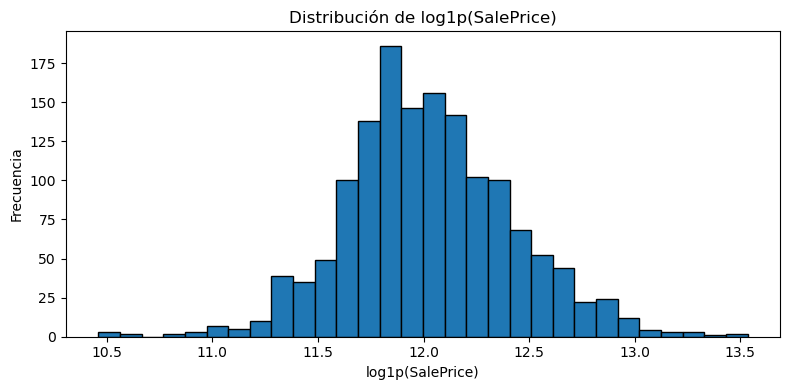

[fig] guardado: /mnt/d/Data/0_Ordenado/LM/IA/fast-ia/proyectos/house-prices/reports/figs/hist_saleprice_log.png


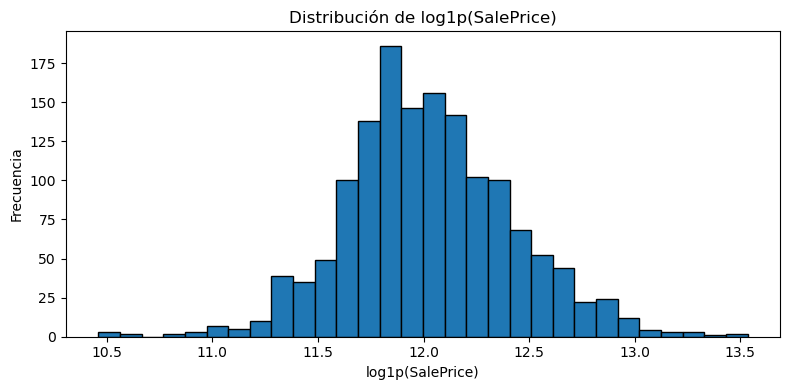

In [64]:
# Crear/actualizar columna log SOLO para EDA (no exportamos aún)
train["SalePrice_log"] = np.log1p(train["SalePrice"])

ylog = train["SalePrice_log"]
print("SalePrice_log — stats")
print(f"mean = {ylog.mean():.3f} | median = {ylog.median():.3f}")
print(f"skew = {ylog.skew():.3f} | kurtosis = {ylog.kurt():.3f}")

# Histograma (log)
plt.figure(figsize=(8,4))
plt.hist(ylog, bins=30, edgecolor="black")
plt.xlabel("log1p(SalePrice)"); plt.ylabel("Frecuencia")
plt.title("Distribución de log1p(SalePrice)")
plt.tight_layout()
plt.show()

# Guardar figura
fig_path_log = FIGS_DIR / "hist_saleprice_log.png"
plt.figure(figsize=(8,4))
plt.hist(ylog, bins=30, edgecolor="black")
plt.xlabel("log1p(SalePrice)"); plt.ylabel("Frecuencia")
plt.title("Distribución de log1p(SalePrice)")
plt.tight_layout()
plt.savefig(fig_path_log, dpi=120)
print(f"[fig] guardado: {fig_path_log}")


[fig] guardado: /mnt/d/Data/0_Ordenado/LM/IA/fast-ia/proyectos/house-prices/reports/figs/qq_saleprice.png
[fig] guardado: /mnt/d/Data/0_Ordenado/LM/IA/fast-ia/proyectos/house-prices/reports/figs/qq_saleprice_log.png


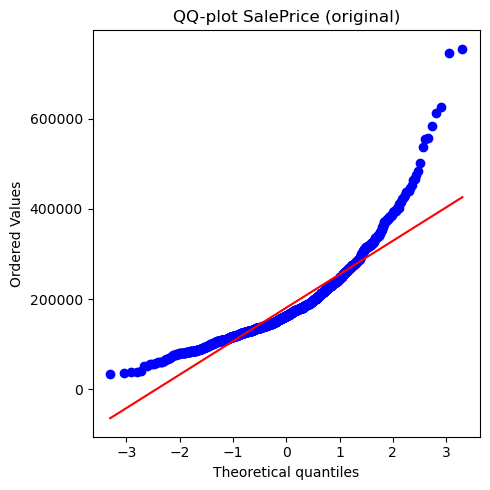

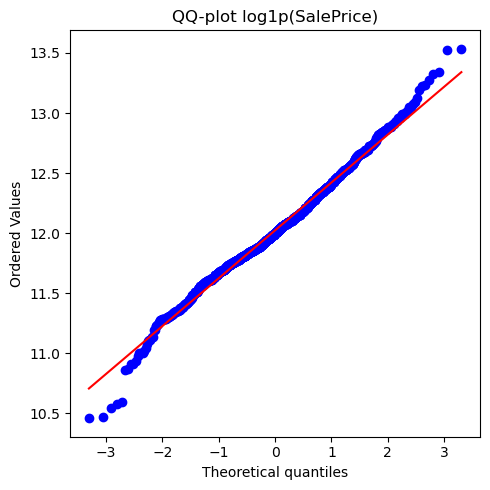

In [65]:
# Intento de QQ-plot con SciPy (opcional). Si no está instalado, se salta.
try:
    from scipy import stats

    plt.figure(figsize=(5,5))
    stats.probplot(y, dist="norm", plot=plt)
    plt.title("QQ-plot SalePrice (original)")
    plt.tight_layout()
    qq1 = FIGS_DIR / "qq_saleprice.png"
    plt.savefig(qq1, dpi=120)
    print(f"[fig] guardado: {qq1}")

    plt.figure(figsize=(5,5))
    stats.probplot(ylog, dist="norm", plot=plt)
    plt.title("QQ-plot log1p(SalePrice)")
    plt.tight_layout()
    qq2 = FIGS_DIR / "qq_saleprice_log.png"
    plt.savefig(qq2, dpi=120)
    print(f"[fig] guardado: {qq2}")

except Exception as e:
    print("[aviso] SciPy no disponible o error en QQ-plot; podés instalarlo más tarde si querés QQ-plots. Detalle:", repr(e))


## 5. Correlaciones numéricas

In [66]:
import pandas as pd
import numpy as np

# Asegurar listas numéricas actualizadas
num_cols = train.select_dtypes(include=["number"]).columns.tolist()

# Quitamos identificadores/targets
cols_for_corr = [c for c in num_cols if c not in ["Id", "SalePrice"]]

# Correls con el target original
corr_with_y = train[cols_for_corr].corrwith(train["SalePrice"]).dropna()
top_y = corr_with_y.reindex(corr_with_y.abs().sort_values(ascending=False).index)

# Correls con el target log (si existe)
if "SalePrice_log" in train:
    corr_with_ylog = train[cols_for_corr].corrwith(train["SalePrice_log"]).dropna()
    top_ylog = corr_with_ylog.reindex(corr_with_ylog.abs().sort_values(ascending=False).index)
else:
    corr_with_ylog = pd.Series(dtype=float)
    top_ylog = corr_with_ylog

print("[Top 15] con SalePrice (abs):")
display(top_y.head(15).to_frame("corr").style.background_gradient(cmap="coolwarm"))

if not top_ylog.empty:
    print("[Top 15] con log1p(SalePrice) (abs):")
    display(top_ylog.head(15).to_frame("corr").style.background_gradient(cmap="coolwarm"))


[Top 15] con SalePrice (abs):


,corr
SalePrice_log,0.948374
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


[Top 15] con log1p(SalePrice) (abs):


,corr
SalePrice_log,1.000000
OverallQual,0.817185
GrLivArea,0.700927
GarageCars,0.680625
GarageArea,0.650888
TotalBsmtSF,0.612134
1stFlrSF,0.596981
FullBath,0.594771
YearBuilt,0.586570
YearRemodAdd,0.565608


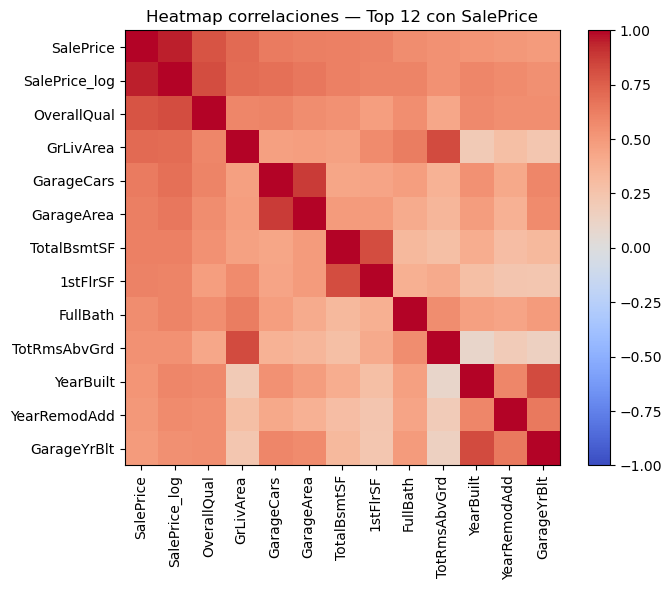

[fig] guardado: /mnt/d/Data/0_Ordenado/LM/IA/fast-ia/proyectos/house-prices/reports/figs/heatmap_top_corr.png


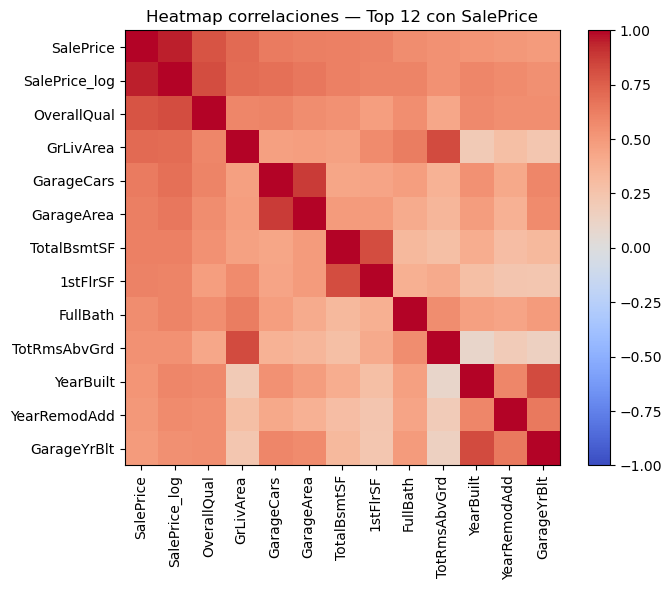

In [67]:
import matplotlib.pyplot as plt

TOPN = 12  # podés ajustar
selected = top_y.index[:TOPN].tolist()
cols_heat = ["SalePrice"] + selected

corr_mat = train[cols_heat].corr()

plt.figure(figsize=(8,6))
im = plt.imshow(corr_mat, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(cols_heat)), cols_heat, rotation=90)
plt.yticks(range(len(cols_heat)), cols_heat)
plt.title(f"Heatmap correlaciones — Top {TOPN} con SalePrice")
plt.tight_layout()
plt.show()

# Guardar figura
heat_path = FIGS_DIR / "heatmap_top_corr.png"
plt.figure(figsize=(8,6))
im = plt.imshow(corr_mat, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(cols_heat)), cols_heat, rotation=90)
plt.yticks(range(len(cols_heat)), cols_heat)
plt.title(f"Heatmap correlaciones — Top {TOPN} con SalePrice")
plt.tight_layout()
plt.savefig(heat_path, dpi=120)
print(f"[fig] guardado: {heat_path}")


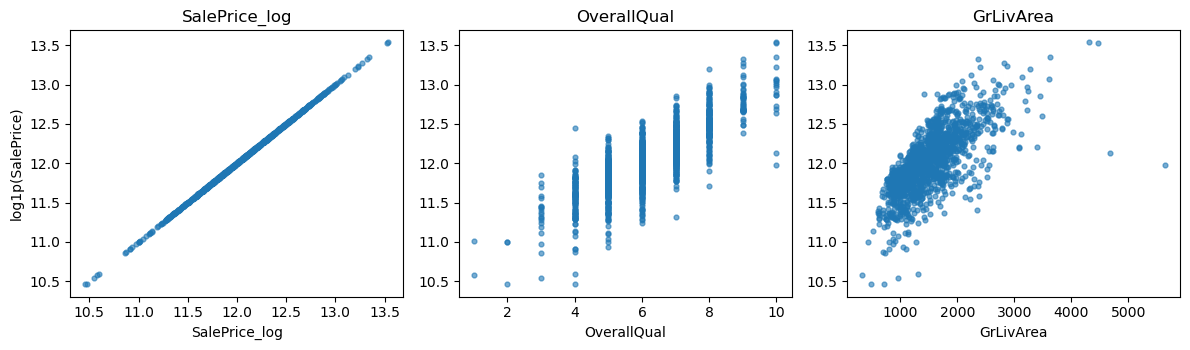

[fig] guardado: /mnt/d/Data/0_Ordenado/LM/IA/fast-ia/proyectos/house-prices/reports/figs/scatter_top3_vs_target.png


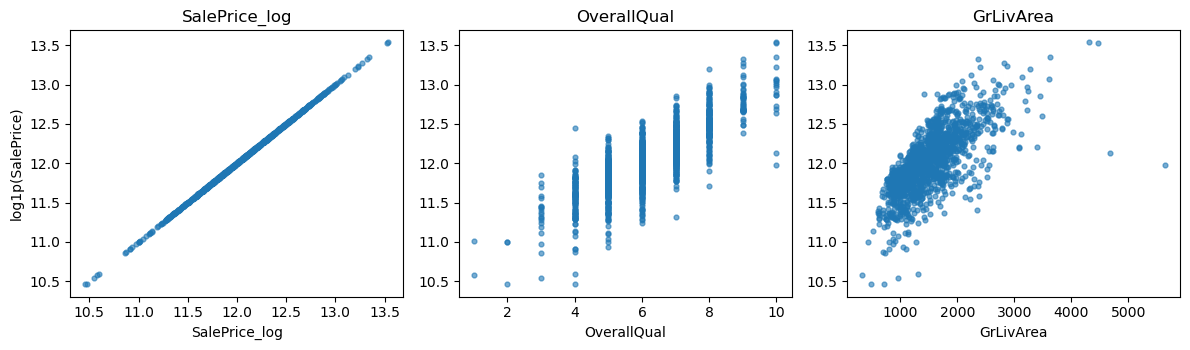

In [68]:
best3 = top_ylog.index[:3].tolist() if not top_ylog.empty else top_y.index[:3].tolist()

plt.figure(figsize=(12,3.6))
for i, col in enumerate(best3, 1):
    plt.subplot(1,3,i)
    if "SalePrice_log" in train:
        plt.scatter(train[col], train["SalePrice_log"], s=12, alpha=0.6)
        plt.ylabel("log1p(SalePrice)" if i==1 else "")
    else:
        plt.scatter(train[col], train["SalePrice"], s=12, alpha=0.6)
        plt.ylabel("SalePrice" if i==1 else "")
    plt.xlabel(col)
    plt.title(f"{col}")
plt.tight_layout(); plt.show()

# (opcional) guardado
sc_path = FIGS_DIR / "scatter_top3_vs_target.png"
plt.figure(figsize=(12,3.6))
for i, col in enumerate(best3, 1):
    plt.subplot(1,3,i)
    if "SalePrice_log" in train:
        plt.scatter(train[col], train["SalePrice_log"], s=12, alpha=0.6)
        plt.ylabel("log1p(SalePrice)" if i==1 else "")
    else:
        plt.scatter(train[col], train["SalePrice"], s=12, alpha=0.6)
        plt.ylabel("SalePrice" if i==1 else "")
    plt.xlabel(col)
    plt.title(f"{col}")
plt.tight_layout(); plt.savefig(sc_path, dpi=120)
print(f"[fig] guardado: {sc_path}")


## 6. Relaciones categóricas

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Target a usar en gráficos
TARGET = "SalePrice_log" if "SalePrice_log" in train.columns else "SalePrice"

# Lista de categóricas “importantes” a explorar primero
cat_focus = [
    "Neighborhood", "HouseStyle", "MSZoning", "BldgType",
    "KitchenQual", "Exterior1st", "SaleCondition"
]

# Algunas “ordinales” que suelen venir como texto o número pero indican calidad/orden
ord_posibles = ["OverallQual", "OverallCond", "ExterQual", "BsmtQual", "GarageFinish", "FireplaceQu"]

# Mantener sólo las que existan en train
cat_focus = [c for c in cat_focus if c in train.columns]
ord_posibles = [c for c in ord_posibles if c in train.columns]

print("[cat_focus]", cat_focus)
print("[ord_posibles]", ord_posibles)


[cat_focus] ['Neighborhood', 'HouseStyle', 'MSZoning', 'BldgType', 'KitchenQual', 'Exterior1st', 'SaleCondition']
[ord_posibles] ['OverallQual', 'OverallCond', 'ExterQual', 'BsmtQual', 'GarageFinish', 'FireplaceQu']


In [70]:
def order_by_median(df, cat_col, target_col, min_count=10):
    tmp = (df[[cat_col, target_col]]
           .dropna(subset=[target_col])
           .groupby(cat_col)[target_col]
           .agg(["count", "median"])
           .sort_values("median", ascending=False))
    tmp = tmp[tmp["count"] >= min_count]  # filtrar categorías muy raras
    order = tmp.index.tolist()
    return tmp, order

# Ejemplos: Neighborhood y KitchenQual
res_neigh, order_neigh = order_by_median(train, "Neighborhood", TARGET, min_count=10) if "Neighborhood" in cat_focus else (pd.DataFrame(), [])
res_kq, order_kq     = order_by_median(train, "KitchenQual", TARGET, min_count=10) if "KitchenQual" in cat_focus else (pd.DataFrame(), [])

print("[Neighborhood] top por mediana:")
display(res_neigh.head(10))
print("[KitchenQual] por mediana:")
display(res_kq)


[Neighborhood] top por mediana:


,count,median
Neighborhood,,
NridgHt,77,12.660331
NoRidge,41,12.616529
StoneBr,25,12.535380
Timber,38,12.339184
Somerst,86,12.326077
Veenker,11,12.292255
Crawfor,51,12.209193
ClearCr,28,12.207326
CollgCr,150,12.191972


[KitchenQual] por mediana:


,count,median
KitchenQual,,
Ex,100,12.665863
Gd,586,12.213051
TA,735,11.827744
Fa,39,11.652696


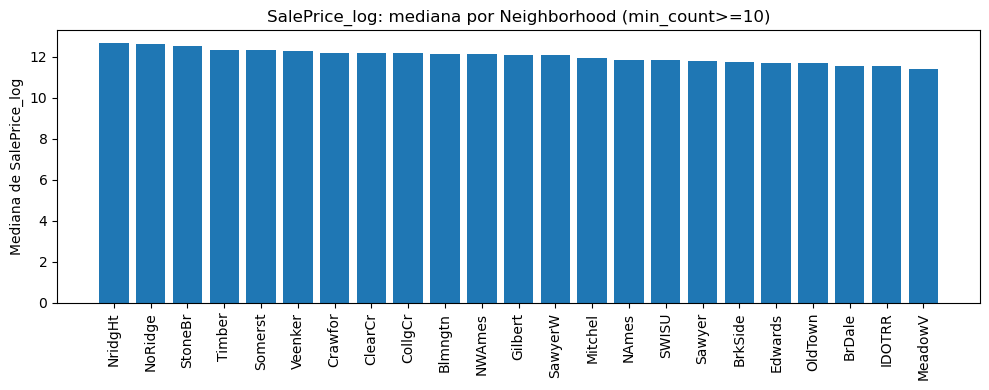

[fig] guardado: /mnt/d/Data/0_Ordenado/LM/IA/fast-ia/proyectos/house-prices/reports/figs/bar_median_by_neighborhood.png


/tmp/ipykernel_16550/3937896224.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order_kq, showfliers=False)


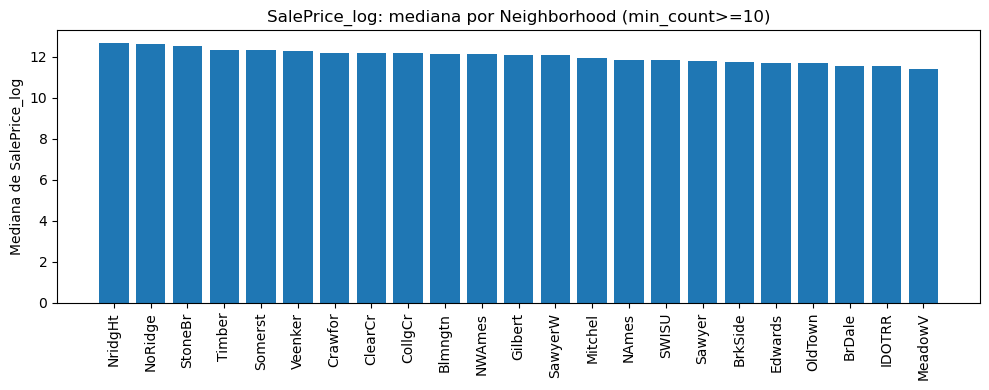

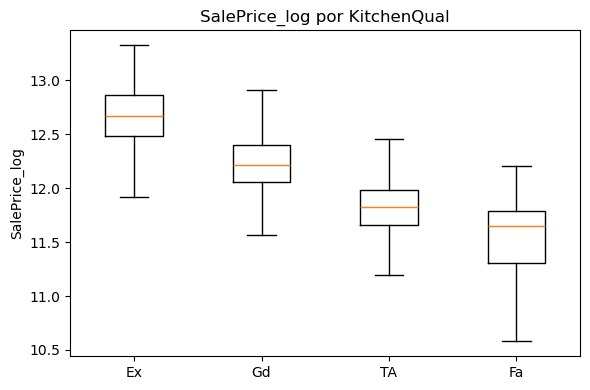

/tmp/ipykernel_16550/3937896224.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order_kq, showfliers=False)
/tmp/ipykernel_16550/3937896224.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(v) for v in oq_vals], showfliers=False)


[fig] guardado: /mnt/d/Data/0_Ordenado/LM/IA/fast-ia/proyectos/house-prices/reports/figs/boxplot_kitchenqual.png


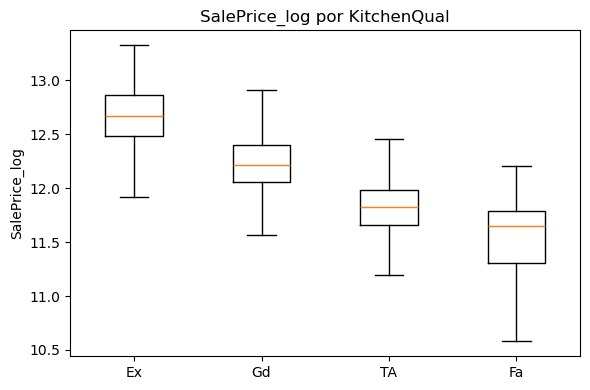

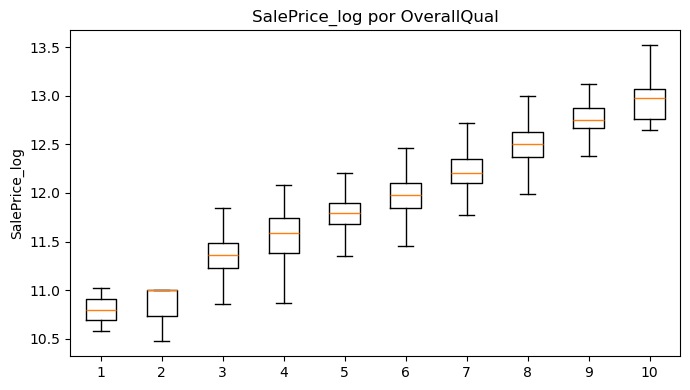

/tmp/ipykernel_16550/3937896224.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(v) for v in oq_vals], showfliers=False)


[fig] guardado: /mnt/d/Data/0_Ordenado/LM/IA/fast-ia/proyectos/house-prices/reports/figs/boxplot_overallqual.png


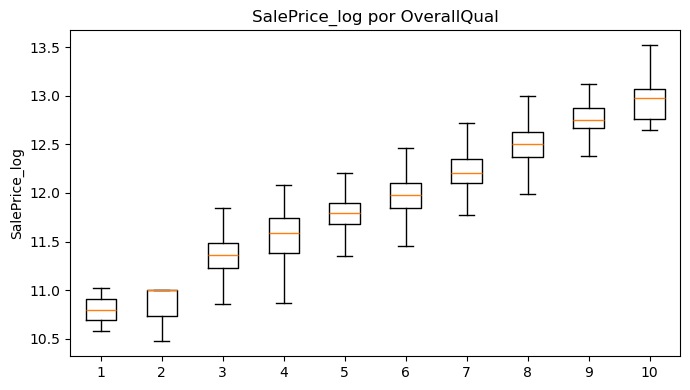

In [71]:
# 1) Barras: mediana por Neighborhood (ordenado)
if len(order_neigh) > 0:
    plt.figure(figsize=(10,4))
    med_vals = res_neigh.loc[order_neigh, "median"]
    plt.bar(order_neigh, med_vals)
    plt.xticks(rotation=90)
    plt.ylabel(f"Mediana de {TARGET}")
    plt.title(f"{TARGET}: mediana por Neighborhood (min_count>=10)")
    plt.tight_layout(); plt.show()

    # Guardar
    figp = FIGS_DIR / "bar_median_by_neighborhood.png"
    plt.figure(figsize=(10,4))
    plt.bar(order_neigh, med_vals)
    plt.xticks(rotation=90)
    plt.ylabel(f"Mediana de {TARGET}")
    plt.title(f"{TARGET}: mediana por Neighborhood (min_count>=10)")
    plt.tight_layout(); plt.savefig(figp, dpi=120)
    print(f"[fig] guardado: {figp}")

# 2) Boxplot: KitchenQual (orden por mediana)
if len(order_kq) > 0:
    data = [train.loc[train["KitchenQual"]==cat, TARGET].dropna() for cat in order_kq]
    plt.figure(figsize=(6,4))
    plt.boxplot(data, labels=order_kq, showfliers=False)
    plt.ylabel(TARGET); plt.title(f"{TARGET} por KitchenQual")
    plt.tight_layout(); plt.show()

    # Guardar
    figp = FIGS_DIR / "boxplot_kitchenqual.png"
    plt.figure(figsize=(6,4))
    plt.boxplot(data, labels=order_kq, showfliers=False)
    plt.ylabel(TARGET); plt.title(f"{TARGET} por KitchenQual")
    plt.tight_layout(); plt.savefig(figp, dpi=120)
    print(f"[fig] guardado: {figp}")

# 3) Boxplot: OverallQual (tratado como categórico ordenado ascendente)
if "OverallQual" in train.columns:
    oq_vals = sorted(train["OverallQual"].dropna().unique().tolist())
    data = [train.loc[train["OverallQual"]==v, TARGET].dropna() for v in oq_vals]
    plt.figure(figsize=(7,4))
    plt.boxplot(data, labels=[str(v) for v in oq_vals], showfliers=False)
    plt.ylabel(TARGET); plt.title(f"{TARGET} por OverallQual")
    plt.tight_layout(); plt.show()

    # Guardar
    figp = FIGS_DIR / "boxplot_overallqual.png"
    plt.figure(figsize=(7,4))
    plt.boxplot(data, labels=[str(v) for v in oq_vals], showfliers=False)
    plt.ylabel(TARGET); plt.title(f"{TARGET} por OverallQual")
    plt.tight_layout(); plt.savefig(figp, dpi=120)
    print(f"[fig] guardado: {figp}")


In [72]:
# Buscar categóricas con muchas categorías raras de baja frecuencia
weak_cats = []
for c in cat_focus:
    vc = train[c].value_counts(dropna=False)
    rare = (vc < 10).sum()
    if rare >= 3 and vc.shape[0] >= 8:  # heurística
        weak_cats.append((c, int(rare), int(vc.shape[0])))
print("[candidatas a agrupar categorías raras]:", weak_cats)


[candidatas a agrupar categorías raras]: [('Exterior1st', 5, 15)]


## 7. Outliers

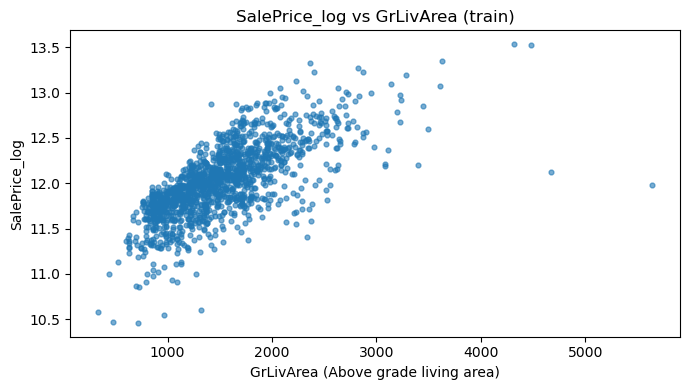

[fig] guardado: /mnt/d/Data/0_Ordenado/LM/IA/fast-ia/proyectos/house-prices/reports/figs/scatter_grlivarea_vs_target.png


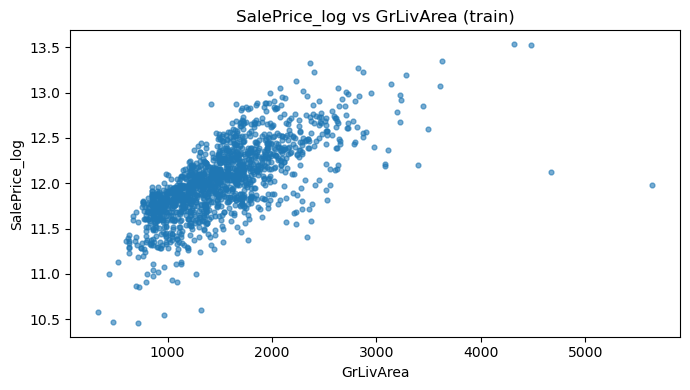

In [73]:
import numpy as np
import matplotlib.pyplot as plt

TARGET = "SalePrice_log" if "SalePrice_log" in train.columns else "SalePrice"

plt.figure(figsize=(7,4))
plt.scatter(train["GrLivArea"], train[TARGET], s=12, alpha=0.6)
plt.xlabel("GrLivArea (Above grade living area)")
plt.ylabel(TARGET)
plt.title(f"{TARGET} vs GrLivArea (train)")
plt.tight_layout(); plt.show()

figp = FIGS_DIR / "scatter_grlivarea_vs_target.png"
plt.figure(figsize=(7,4))
plt.scatter(train["GrLivArea"], train[TARGET], s=12, alpha=0.6)
plt.xlabel("GrLivArea"); plt.ylabel(TARGET)
plt.title(f"{TARGET} vs GrLivArea (train)")
plt.tight_layout(); plt.savefig(figp, dpi=120)
print(f"[fig] guardado: {figp}")


[outliers] candidatos por regla (GrLivArea>4000 & SalePrice<300000): 2
Índices: [523, 1298] ...


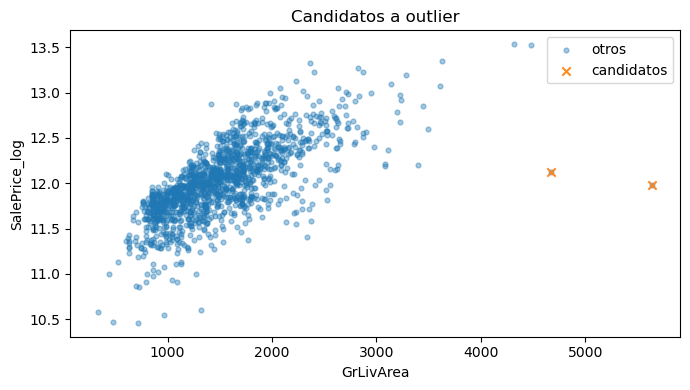

In [74]:
# Heurística estándar del dataset:
# Outliers: casas con GrLivArea > 4000 y precio bajo respecto al mercado.
# Para dejarlo reproducible sin "a ojo", usamos un umbral en precio.
low_price_thr = 300_000  # ajustable: si tu scatter muestra corte distinto, lo anotás en bitácora

mask_out = (train["GrLivArea"] > 4000) & (train["SalePrice"] < low_price_thr)
idx_out = train.index[mask_out].tolist()

print(f"[outliers] candidatos por regla (GrLivArea>4000 & SalePrice<{low_price_thr}): {len(idx_out)}")
print("Índices:", idx_out[:10], "...")

# Visual rápido de estos puntos:
plt.figure(figsize=(7,4))
plt.scatter(train["GrLivArea"], train[TARGET], s=12, alpha=0.4, label="otros")
plt.scatter(train.loc[idx_out, "GrLivArea"], train.loc[idx_out, TARGET], s=36, alpha=0.9, label="candidatos", marker="x")
plt.xlabel("GrLivArea"); plt.ylabel(TARGET); plt.legend()
plt.title("Candidatos a outlier")
plt.tight_layout(); plt.show()


In [75]:
# Diagnóstico auxiliar sobre algunas numéricas relevantes
check_cols = [c for c in ["GrLivArea","TotalBsmtSF","1stFlrSF","LotFrontage"] if c in train.columns]
iqr_flags = {}

for c in check_cols:
    s = train[c].dropna()
    q1, q3 = np.percentile(s, [25, 75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    flag = train[c].lt(lo) | train[c].gt(hi)
    iqr_flags[c] = int(flag.sum())
    print(f"[IQR] {c}: outliers={int(flag.sum())} (lo={lo:.1f}, hi={hi:.1f})")

print("[IQR] resumen:", iqr_flags)


[IQR] GrLivArea: outliers=31 (lo=158.6, hi=2747.6)
[IQR] TotalBsmtSF: outliers=61 (lo=42.0, hi=2052.0)
[IQR] 1stFlrSF: outliers=20 (lo=118.1, hi=2155.1)
[IQR] LotFrontage: outliers=88 (lo=27.5, hi=111.5)
[IQR] resumen: {'GrLivArea': 31, 'TotalBsmtSF': 61, '1stFlrSF': 20, 'LotFrontage': 88}


In [76]:
# Decisión: remover SOLO los candidatos clásicos de B
train_wo_outliers = train.drop(index=idx_out).copy()
print("train original:", train.shape, "| train_wo_outliers:", train_wo_outliers.shape)

# Guardamos los índices removidos en una variable (para auditar más tarde)
removed_outliers_idx = idx_out


train original: (1460, 82) | train_wo_outliers: (1458, 82)


## 8. Skew (asimetría)

In [77]:
import numpy as np
import pandas as pd

# Elegimos la base de referencia para medir skew
df_ref = train_wo_outliers if 'train_wo_outliers' in globals() else train

# Columnas numéricas candidatas (sin Id ni targets)
num_base = [c for c in df_ref.select_dtypes(include='number').columns
            if c not in ['Id', 'SalePrice', 'SalePrice_log']]

# Reporte de skew
skew_vals = df_ref[num_base].skew(numeric_only=True).sort_values(ascending=False)
skew_report = pd.DataFrame({'skew': skew_vals})
display(skew_report.head(20))

# Chequeo de valores negativos (para decidir si usamos log1p sin shift)
neg_min = df_ref[num_base].min().sort_values()
neg_cols = neg_min[neg_min < 0].index.tolist()
print("[skew] columnas con valores negativos (revisar antes de log1p):", neg_cols if neg_cols else "Ninguna")


,skew
MiscVal,24.460085
PoolArea,15.948945
LotArea,12.573925
3SsnPorch,10.297106
LowQualFinSF,9.004955
KitchenAbvGr,4.484883
BsmtFinSF2,4.251925
ScreenPorch,4.118929
BsmtHalfBath,4.100114
EnclosedPorch,3.087164


[skew] columnas con valores negativos (revisar antes de log1p): Ninguna


In [78]:
SKEW_THR = 0.75  # umbral clásico y efectivo
skewed_feats = skew_report.index[skew_report['skew'] > SKEW_THR].tolist()

# Algunas numéricas "conteo/superficie" toleran bien log1p; mantener fuera identificadores o proporciones ya estabilizadas
blacklist = set(['OverallQual', 'OverallCond'])  # ordinales fuertes que tal vez prefieras NO log-transformar
skewed_feats = [c for c in skewed_feats if c not in blacklist]

print(f"[skew] candidatas a log1p (skew>{SKEW_THR}): {len(skewed_feats)}")
print(skewed_feats[:20])


[skew] candidatas a log1p (skew>0.75): 20
['MiscVal', 'PoolArea', 'LotArea', '3SsnPorch', 'LowQualFinSF', 'KitchenAbvGr', 'BsmtFinSF2', 'ScreenPorch', 'BsmtHalfBath', 'EnclosedPorch', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'LotFrontage', 'MSSubClass', 'GrLivArea', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1']


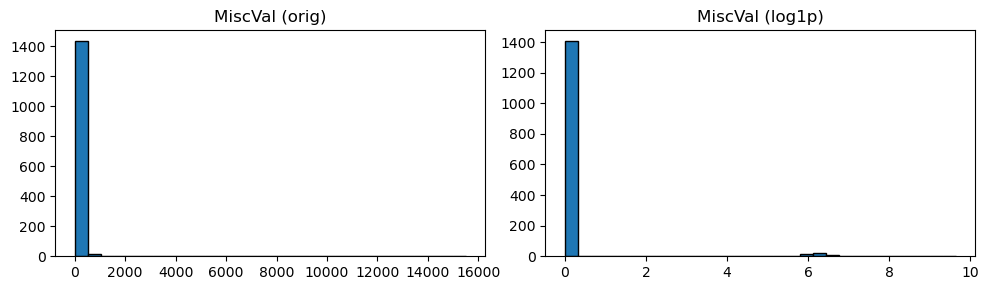

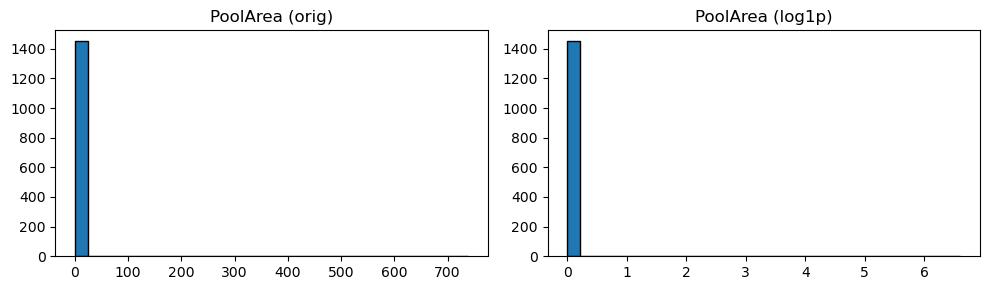

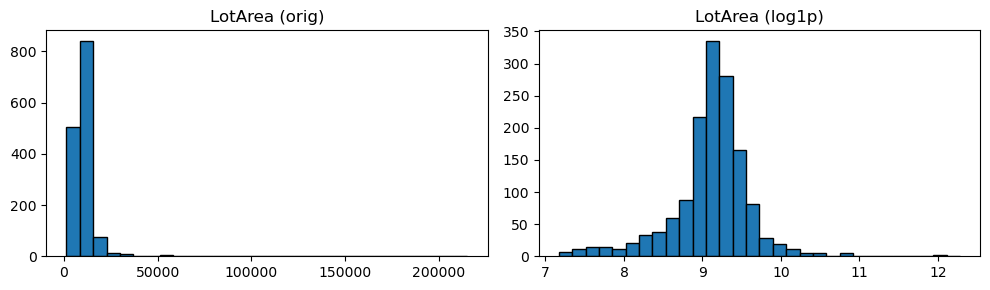

In [79]:
import matplotlib.pyplot as plt

preview = skewed_feats[:3]
for col in preview:
    x = df_ref[col].dropna()
    if (x < 0).any():
        print(f"[skip] {col}: negativos, omito preview log1p")
        continue
    fig = plt.figure(figsize=(10,3))
    plt.subplot(1,2,1); plt.hist(x, bins=30, edgecolor="black"); plt.title(f"{col} (orig)")
    y = np.log1p(x)
    plt.subplot(1,2,2); plt.hist(y, bins=30, edgecolor="black"); plt.title(f"{col} (log1p)")
    plt.tight_layout(); plt.show()


In [ ]:
from pathlib import Path

# Guardar reporte y lista para usar en el paso de limpieza/modelado
REPORTS_DIR = FIGS_DIR.parent  # reports/
skew_csv = REPORTS_DIR / "skew_report.csv"
skew_list_txt = REPORTS_DIR / "skewed_feats.txt"

skew_report.to_csv(skew_csv, index=True)
with open(skew_list_txt, "w", encoding="utf-8") as f:
    for c in skewed_feats:
        f.write(f"{c}\n")

print(f"[ok] guardado reporte: {skew_csv}")
print(f"[ok] guardada lista:   {skew_list_txt}")

[ok] guardado reporte: /mnt/d/Data/0_Ordenado/LM/IA/fast-ia/proyectos/house-prices/reports/skew_report.csv
[ok] guardada lista:   /mnt/d/Data/0_Ordenado/LM/IA/fast-ia/proyectos/house-prices/reports/skewed_feats.txt


## 9. Exportar dataset limpio

In [81]:
from pathlib import Path
import numpy as np
import pandas as pd

# Detectar raíz del proyecto (si estamos en notebooks/, subir un nivel)
CWD = Path.cwd().resolve()
PROJECT_ROOT = CWD.parent if CWD.name == "notebooks" else CWD
REPORTS_DIR = PROJECT_ROOT / "reports"
FIGS_DIR = REPORTS_DIR / "figs"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)
FIGS_DIR.mkdir(parents=True, exist_ok=True)

# ---------- A) train_wo_outliers (si no existe) ----------
TARGET = "SalePrice_log" if "SalePrice_log" in train.columns else "SalePrice"

if 'train_wo_outliers' in globals():
    print("[ok] train_wo_outliers ya existe:", train_wo_outliers.shape)
else:
    # Regla clásica: GrLivArea > 4000 y SalePrice < 300k
    low_price_thr = 300_000
    mask_out = (train["GrLivArea"] > 4000) & (train["SalePrice"] < low_price_thr)
    idx_out = train.index[mask_out].tolist()
    train_wo_outliers = train.drop(index=idx_out).copy()
    print(f"[creado] train_wo_outliers: {train_wo_outliers.shape} | removidos: {len(idx_out)} -> {idx_out}")

# ---------- B) skewed_feats.txt (si no existe) ----------
skew_list_path = REPORTS_DIR / "skewed_feats.txt"
skew_report_path = REPORTS_DIR / "skew_report.csv"

need_skew = not skew_list_path.exists()

if need_skew:
    df_ref = train_wo_outliers if 'train_wo_outliers' in globals() else train
    num_base = [c for c in df_ref.select_dtypes(include='number').columns
                if c not in ['Id','SalePrice','SalePrice_log']]

    skew_vals = df_ref[num_base].skew(numeric_only=True).sort_values(ascending=False)
    skew_report = pd.DataFrame({'skew': skew_vals})
    skew_report.to_csv(skew_report_path, index=True)

    SKEW_THR = 0.75
    blacklist = set(['OverallQual','OverallCond'])  # opcional
    skewed_feats = [c for c in skew_report.index if skew_report.loc[c, 'skew'] > SKEW_THR and c not in blacklist]

    with open(skew_list_path, "w", encoding="utf-8") as f:
        for c in skewed_feats:
            f.write(f"{c}\n")

    print(f"[creado] {skew_list_path} con {len(skewed_feats)} columnas; reporte: {skew_report_path}")
else:
    with open(skew_list_path, "r", encoding="utf-8") as f:
        skewed_feats = [line.strip() for line in f if line.strip()]
    print(f"[ok] skewed_feats ya existe ({len(skewed_feats)} columnas): {skew_list_path}")


[ok] train_wo_outliers ya existe: (1458, 82)
[ok] skewed_feats ya existe (20 columnas): /mnt/d/Data/0_Ordenado/LM/IA/fast-ia/proyectos/house-prices/reports/skewed_feats.txt


In [82]:
import pandas as pd
import numpy as np
from pathlib import Path

# Base de ajuste para imputación (sin outliers)
df_fit = train_wo_outliers if 'train_wo_outliers' in globals() else train

# Grupos "estructurales": si está todo NA, significa "no tiene"
GROUPS = {
    "Garage":    [c for c in train.columns if c.startswith("Garage")],
    "Bsmt":      [c for c in train.columns if c.startswith("Bsmt")],
    "Fireplace": [c for c in train.columns if c.startswith("Fireplace")],  # FireplaceQu es categórica; Fireplaces es conteo
    "Pool":      [c for c in train.columns if c.startswith("Pool")],
    "Masonry":   [c for c in train.columns if c.startswith("MasVnr")],     # MasVnrType/Area
}
SINGLE_CAT_NONE = [c for c in ["Alley","Fence","MiscFeature"] if c in train.columns]

def split_num_cat(df, cols):
    cols = [c for c in cols if c in df.columns]
    num = [c for c in cols if pd.api.types.is_numeric_dtype(df[c])]
    cat = [c for c in cols if c not in num]
    return num, cat

# Cargar lista de features a log-transformar
skew_list_path = Path(PROJECT_ROOT) / "reports" / "skewed_feats.txt"
with open(skew_list_path, "r", encoding="utf-8") as f:
    SKEWED_FEATS = [line.strip() for line in f if line.strip()]

print("[fit] grupos:", {k: len(v) for k,v in GROUPS.items()})
print("[fit] single_cat_none:", SINGLE_CAT_NONE)
print(f"[fit] skewed_feats ({len(SKEWED_FEATS)}):", SKEWED_FEATS[:10], "...")


[fit] grupos: {'Garage': 7, 'Bsmt': 10, 'Fireplace': 2, 'Pool': 2, 'Masonry': 2}
[fit] single_cat_none: ['Alley', 'Fence', 'MiscFeature']
[fit] skewed_feats (20): ['MiscVal', 'PoolArea', 'LotArea', '3SsnPorch', 'LowQualFinSF', 'KitchenAbvGr', 'BsmtFinSF2', 'ScreenPorch', 'BsmtHalfBath', 'EnclosedPorch'] ...


In [83]:
# 1) Reglas estructurales: dicts para fillna
fillna_num_estruct = {}
fillna_cat_estruct = {}

for gname, cols in GROUPS.items():
    num_cols, cat_cols = split_num_cat(df_fit, cols)
    for c in num_cols:
        fillna_num_estruct[c] = 0
    for c in cat_cols:
        fillna_cat_estruct[c] = "None"

for c in SINGLE_CAT_NONE:
    fillna_cat_estruct[c] = "None"

# 2) LotFrontage por mediana de Neighborhood (si existen ambas)
lotfront_by_nbhd = {}
if "LotFrontage" in df_fit.columns and "Neighborhood" in df_fit.columns:
    lotfront_by_nbhd = df_fit.groupby("Neighborhood")["LotFrontage"].median().to_dict()
    lotfront_global = float(df_fit["LotFrontage"].median())
else:
    lotfront_global = None

# 3) Resto de numéricas: mediana global (train_wo_outliers)
num_all = [c for c in df_fit.select_dtypes(include="number").columns if c not in ["SalePrice","SalePrice_log","Id"]]
num_median = df_fit[num_all].median(numeric_only=True).to_dict()

# 4) Resto de categóricas: moda global (train_wo_outliers)
cat_all = [c for c in df_fit.columns if c not in num_all + ["SalePrice","SalePrice_log","Id"]]
cat_mode = {}
for c in cat_all:
    try:
        cat_mode[c] = df_fit[c].mode(dropna=True)[0]
    except Exception:
        # si todas NA, usar "None" por seguridad
        cat_mode[c] = "None"

print(f"[fit] num estructurales: {len(fillna_num_estruct)} | cat estructurales: {len(fillna_cat_estruct)}")
print(f"[fit] num_median: {len(num_median)} | cat_mode: {len(cat_mode)}")
if lotfront_by_nbhd:
    print(f"[fit] LotFrontage por Neighborhood: {len(lotfront_by_nbhd)} vecindarios (fallback={lotfront_global})")


[fit] num estructurales: 11 | cat estructurales: 15
[fit] num_median: 36 | cat_mode: 43
[fit] LotFrontage por Neighborhood: 25 vecindarios (fallback=69.0)


In [85]:
def apply_imputation(df, is_train=True):
    X = df.copy()

    # MSSubClass como categórica (num->cat)
    if "MSSubClass" in X.columns:
        X["MSSubClass"] = X["MSSubClass"].astype(str)

    # 1) Estructurales
    for c, v in fillna_num_estruct.items():
        if c in X.columns:
            X[c] = X[c].fillna(v)
    for c, v in fillna_cat_estruct.items():
        if c in X.columns:
            X[c] = X[c].fillna(v)

    # 2) LotFrontage por Neighborhood (si existen)
    if "LotFrontage" in X.columns and "Neighborhood" in X.columns and lotfront_by_nbhd:
        lf_map = X["Neighborhood"].map(lotfront_by_nbhd)
        X["LotFrontage"] = X["LotFrontage"].fillna(lf_map)
        if X["LotFrontage"].isna().any() and (lotfront_global is not None):
            X["LotFrontage"] = X["LotFrontage"].fillna(lotfront_global)

    # 3) Resto numéricas (mediana global aprendida en train)
    for c, med in num_median.items():
        if c in X.columns:
            X[c] = X[c].fillna(med)

    # 4) Resto categóricas (moda global aprendida en train)
    for c, modev in cat_mode.items():
        if c in X.columns and pd.api.types.is_object_dtype(X[c]):
            X[c] = X[c].fillna(modev)

    # 5) Transformaciones log1p SOLO en columnas numéricas (después de imputar)
    feats_to_log = [
        c for c in SKEWED_FEATS
        if c in X.columns and pd.api.types.is_numeric_dtype(X[c])
    ]
    for c in feats_to_log:
        xc = X[c]
        if (xc < 0).any():
            minc = float(xc.min())
            X[c] = np.log1p(xc - minc + 1)  # seguridad si hubiera negativos
        else:
            X[c] = np.log1p(xc)

    # Aviso (opcional): columnas de SKEWED_FEATS omitidas por no numéricas
    dropped = [
        c for c in SKEWED_FEATS
        if c in X.columns and not pd.api.types.is_numeric_dtype(X[c])
    ]
    if dropped:
        print("[warn] omito log1p en no-numéricas:", dropped[:10], "...")

    return X

# Construir copias base
train_base = train_wo_outliers.copy() if 'train_wo_outliers' in globals() else train.copy()
test_base  = test.copy()

# Aplicar imputación y transformaciones
train_clean = apply_imputation(train_base, is_train=True)
test_clean  = apply_imputation(test_base,  is_train=False)

# Verificaciones duras
miss_train = int(train_clean.isna().sum().sum())
miss_test  = int(test_clean.isna().sum().sum())
print(f"[miss] train_clean nulos={miss_train} | test_clean nulos={miss_test}")
assert miss_train == 0 and miss_test == 0, "Aún quedan nulos: revisar reglas"

# Alinear columnas: test no debe tener SalePrice / SalePrice_log
extra_in_test  = set(test_clean.columns)  - set(train_clean.columns) - {"SalePrice"}
extra_in_train = set(train_clean.columns) - set(test_clean.columns)  - {"SalePrice","SalePrice_log"}
print("[cols] extra_en_test:", extra_in_test, "| extra_en_train:", extra_in_train)

print("[ok] train_clean y test_clean listos en memoria.")
train_clean.shape, test_clean.shape


[warn] omito log1p en no-numéricas: ['MSSubClass'] ...
[warn] omito log1p en no-numéricas: ['MSSubClass'] ...
[miss] train_clean nulos=0 | test_clean nulos=0
[cols] extra_en_test: set() | extra_en_train: set()
[ok] train_clean y test_clean listos en memoria.


((1458, 82), (1459, 80))

In [87]:
# === Exportar y verificar datasets limpios (robusto a "None") ===
from pathlib import Path
import pandas as pd

# 0) Rutas
CWD = Path.cwd().resolve()
PROJECT_ROOT = CWD.parent if CWD.name == "notebooks" else CWD
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

# 1) Preparar copias para guardar
cols_drop_train_only = ["SalePrice_log"]  # columnas solo de EDA que no deben ir al CSV final
train_to_save = train_clean.drop(columns=cols_drop_train_only, errors="ignore").copy()
assert "SalePrice" not in test_clean.columns, "test_clean no debe incluir SalePrice"
test_to_save = test_clean.copy()

# 2) Blindaje: evitar que al releer se interprete "None" como NA
for df_ in (train_to_save, test_to_save):
    obj_cols = df_.select_dtypes(include="object").columns
    if len(obj_cols) > 0:
        # Reemplazo literal "None" -> "None_"
        df_.loc[:, obj_cols] = df_.loc[:, obj_cols].replace("None", "None_")

# 3) Guardado idempotente
train_csv = DATA_PROCESSED / "train_clean.csv"
test_csv  = DATA_PROCESSED / "test_clean.csv"
train_to_save.to_csv(train_csv, index=False)
test_to_save.to_csv(test_csv, index=False)
print(f"[save] {train_csv}")
print(f"[save] {test_csv}")

# 4) Verificación releyendo desde disco (no tratar "None_" / "None" como NA)
train_chk = pd.read_csv(train_csv, keep_default_na=False)
test_chk  = pd.read_csv(test_csv,  keep_default_na=False)

# 4.1) Nulos
nmiss_train = int(train_chk.isna().sum().sum())
nmiss_test  = int(test_chk.isna().sum().sum())
print(f"[check] nulos: train={nmiss_train} | test={nmiss_test}")
assert nmiss_train == 0 and nmiss_test == 0, "Hay nulos: revisar imputación"

# 4.2) Shapes
print(f"[check] shape train_clean.csv: {train_chk.shape}")
print(f"[check] shape test_clean.csv : {test_chk.shape}")

# 4.3) Columnas alineadas (SalePrice solo en train)
train_cols = set(train_chk.columns)
test_cols  = set(test_chk.columns)
extra_in_train = sorted(list(train_cols - test_cols - {'SalePrice'}))
extra_in_test  = sorted(list(test_cols - (train_cols - {'SalePrice'})))
print("[check] columnas extra en train (no permitidas):", extra_in_train)
print("[check] columnas extra en test  (no permitidas):", extra_in_test)
assert not extra_in_train and not extra_in_test, "Columnas desalineadas"

assert "SalePrice" in train_chk.columns and "SalePrice" not in test_chk.columns, \
       "SalePrice debe estar solo en train_clean.csv"

print("[OK] Exportación y verificación completadas.")


[save] /mnt/d/Data/0_Ordenado/LM/IA/fast-ia/proyectos/house-prices/data/processed/train_clean.csv
[save] /mnt/d/Data/0_Ordenado/LM/IA/fast-ia/proyectos/house-prices/data/processed/test_clean.csv
[check] nulos: train=0 | test=0
[check] shape train_clean.csv: (1458, 81)
[check] shape test_clean.csv : (1459, 80)
[check] columnas extra en train (no permitidas): []
[check] columnas extra en test  (no permitidas): []
[OK] Exportación y verificación completadas.


## 10. Conclusiones y próximos pasos